In [1]:
import os
import pathlib

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
CAT_DATASET = './CAT_DATASET_v2'
dataset_dir = pathlib.Path(CAT_DATASET)

In [5]:
img_height = 331
img_width = 331
epochs = 10
batch_size = 4096

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  validation_split=0.2)

In [7]:
train_gen = train_datagen.flow_from_directory(CAT_DATASET,
                                              target_size=(img_width, img_height),
                                              batch_size=256,
                                              class_mode='categorical',
                                              subset='training')

Found 2292 images belonging to 13 classes.


In [8]:
val_gen = train_datagen.flow_from_directory(CAT_DATASET,
                                              target_size=(img_width, img_height),
                                              batch_size=256,
                                              class_mode='categorical',
                                              subset='validation')

Found 571 images belonging to 13 classes.


In [9]:
num_class = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print(class_names)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Domestic Short-Haired', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx']


### Model

In [10]:
model_base = keras.applications.InceptionResNetV2(input_shape=(img_width,img_height,3),
                                            include_top=False,
                                            weights='imagenet')

model = keras.models.Sequential()
for layer in model_base.layers:
    layer.trainable = False

model.add(model_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(13, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 9, 9, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 124416)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               63701504  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 13)                845       
Total params: 118,113,005
Trainable params: 63,776,269
Non-trainable params: 54,336,736
__________________________________

In [11]:
history = model.fit(train_gen,
                    validation_data = val_gen, 
                    epochs = epochs)

Epoch 1/10
9/9 [==============================] - 659s 74s/step - loss: 19.5732 - accuracy: 0.1141 - val_loss: 12.5781 - val_accuracy: 0.3222
Epoch 2/10
9/9 [==============================] - 693s 78s/step - loss: 9.4684 - accuracy: 0.3092 - val_loss: 3.0408 - val_accuracy: 0.4974
Epoch 3/10
9/9 [==============================] - 669s 75s/step - loss: 2.7267 - accuracy: 0.5160 - val_loss: 1.6456 - val_accuracy: 0.6462
Epoch 4/10
9/9 [==============================] - 681s 76s/step - loss: 1.5120 - accuracy: 0.6839 - val_loss: 0.9308 - val_accuracy: 0.7531
Epoch 5/10
9/9 [==============================] - 687s 77s/step - loss: 0.8929 - accuracy: 0.7620 - val_loss: 0.6440 - val_accuracy: 0.7986
Epoch 6/10
9/9 [==============================] - 631s 71s/step - loss: 0.5880 - accuracy: 0.8200 - val_loss: 0.6622 - val_accuracy: 0.7951
Epoch 7/10
9/9 [==============================] - 642s 73s/step - loss: 0.4136 - accuracy: 0.8678 - val_loss: 0.5357 - val_accuracy: 0.8389
Epoch 8/10
9/9 [==

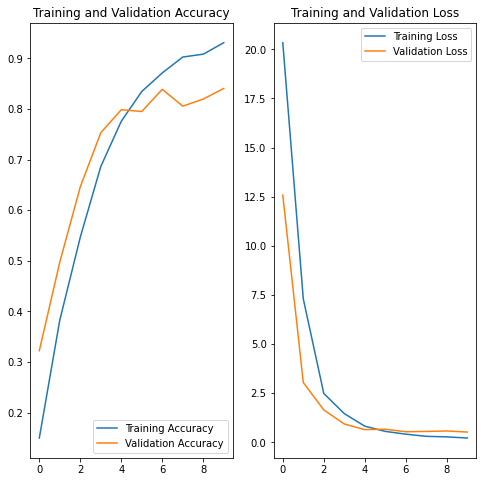

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model.save('./MODEL_V3.h5', include_optimizer=False)

In [14]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [16]:
from urllib.parse import urlparse
url_cat_picture = "https://www.catster.com/wp-content/uploads/2018/01/Ragdoll-cat-on-blue-backdrop-.jpg"
a = urlparse(url_cat_picture)
file_name = os.path.basename(a.path)

cat_path = tf.keras.utils.get_file(f'./{file_name}', origin=url_cat_picture, cache_dir='./')
img = keras.preprocessing.image.load_img(
    cat_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)], round(100 * np.max(score)), "%")

172032/165231 [===============================] - 1s 3us/step
Ragdoll 18 %


In [ ]:
print(predictions)